In [1]:

#data analysis
import pandas as pd
import numpy as np
from nltk.collocations import *
import nltk
from nltk import FreqDist
import re



#Plotting
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.graph_objs as go
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#loading dataset
bd_complaints = "Consumer_Complaints.csv"
df = pd.read_csv(bd_complaints)

C:\Users\Bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
#Sample dataset
df2 = df.sample(100000)

#df2 = df.copy()

In [4]:
df2.head(10)

Date received                                            Product  \
35721      08/08/2019  Credit reporting, credit repair services, or o...   
1322709    12/25/2012                                        Credit card   
464287     12/19/2017  Credit reporting, credit repair services, or o...   
555551     08/13/2017  Credit reporting, credit repair services, or o...   
814632     06/03/2016                                           Mortgage   
283998     08/23/2018  Credit reporting, credit repair services, or o...   
302206     07/29/2018  Credit reporting, credit repair services, or o...   
904627     12/01/2015                                   Credit reporting   
1086936    10/22/2014                                   Credit reporting   
122251     04/19/2019                        Credit card or prepaid card   

                                        Sub-product  \
35721                              Credit reporting   
1322709                                         NaN   
464287                             Credit reporting   
555551                             Credit reporting   
814632                               Other mortgage   
283998                             Credit reporting   
302206                             Credit reporting   
904627                                          NaN   
1086936                                         NaN   
122251   General-purpose credit card or charge card   

                                                     Issue  \
35721                 Incorrect information on your report   
1322709                                     Payoff process   
464287   Problem with a credit reporting company's inve...   
555551                Incorrect information on your report   
814632            Loan modification,collection,foreclosure   
283998                         Improper use of your report   
302206   Problem with a credit reporting company's inve...   
904627            Credit reporting company's investigation   
1086936           Credit monitoring or identity protection   
122251                                Closing your account   

                                                 Sub-issue  \
35721                  Information belongs to someone else   
1322709                                                NaN   
464287   Their investigation did not fix an error on yo...   
555551                 Information belongs to someone else   
814632                                                 NaN   
283998   Credit inquiries on your report that you don't...   
302206   Was not notified of investigation status or re...   
904627                      Inadequate help over the phone   
1086936                          Account terms and changes   
122251                         Company closed your account   

                              Consumer complaint narrative  \
35721                                                  NaN   
1322709                                                NaN   
464287                                                 NaN   
555551                                                 NaN   
814632                                                 NaN   
283998                                                 NaN   
302206   I am filing this complaint because Equifax has...   
904627   chex systems has account or file on me and I a...   
1086936                                                NaN   
122251   Chase sent me a letter dated XX/XX/XXXX that t...   

                                   Company public response  \
35721    Company has responded to the consumer and the ...   
1322709                                                NaN   
464287   Company has responded to the consumer and the ...   
555551   Company has responded to the consumer and the ...   
814632                                                 NaN   
283998                                                 NaN   
302206                                                 NaN   
904627    Company ch

In [7]:
#Transforming date into date object
df2['new_date'] = pd.to_datetime(df2['Date received'], 
                                 format='%m/%d/%Y', 
                                 errors='coerce')
df2['new_date'] = pd.to_datetime(df2['new_date'])


#Extracting year, month, day_name
df2['year'] = pd.DatetimeIndex(df2['new_date']).year
df2['month'] = pd.DatetimeIndex(df2['new_date']).month
df2['month_name'] = pd.DatetimeIndex(df2['new_date']).month_name()
df2['day'] = pd.DatetimeIndex(df2['new_date']).day_name()
df2['day_number'] = pd.DatetimeIndex(df2['new_date']).day

#Counting the number of words of every complaint
df2['len_complaint'] = df2['Consumer complaint narrative'].str.split().str.len()

#Sorting

df2 = df2.sort_values(by=['new_date'],ascending=False)


df2.head(5)

Date received                                            Product  \
15    10/01/2019                                    Debt collection   
19    10/01/2019                                    Debt collection   
22    09/30/2019  Credit reporting, credit repair services, or o...   
51    09/30/2019                                    Debt collection   
82    09/30/2019                                    Debt collection   

         Sub-product                                 Issue  \
15      Medical debt       Written notification about debt   
19      Medical debt       Written notification about debt   
22  Credit reporting  Incorrect information on your report   
51        Other debt    False statements or representation   
82     I do not know     Attempts to collect debt not owed   

                                           Sub-issue  \
15         Didn't receive notice of right to dispute   
19  Didn't receive enough information to verify debt   
22               Information belongs to someone else   
51                 Attempted to collect wrong amount   
82                 Debt was result of identity theft   

   Consumer complaint narrative  \
15                          NaN   
19                          NaN   
22                          NaN   
51                          NaN   
82                          NaN   

                              Company public response  \
15                                                NaN   
19                                                NaN   
22                                                NaN   
51  Company has responded to the consumer and the ...   
82                                                NaN   

                            Company State ZIP code  ... Timely response?  \
15                 Centron Services    WA    98201  ...              Yes   
19  AMERICAN ADJUSTMENT BUREAU,INC.    CT    06042  ...              Yes   
22                    EQUIFAX, INC.    AL    35405  ...              Yes   
51       Convergent Resources, Inc.    FL    32738  ...              Yes   
82  Complete Credit Solutions, Inc.    CA    956XX  ...              Yes   

   Consumer disputed? Complaint ID   new_date  year month month_name      day  \
15                NaN      3392568 2019-10-01  2019    10    October  Tuesday   
19                NaN      3391381 2019-10-01  2019    10    October  Tuesday   
22                NaN      3390362 2019-09-30  2019     9  September   Monday   
51                NaN      3390426 2019-09-30  2019     9  September   Monday   
82                NaN      3390913 2019-09-30  2019     9  September   Monday   

   day_number  len_complaint  
15          1            NaN  
19          1            NaN  
22         30            NaN  
51         30            NaN  
82         30            NaN  

[5 rows x 25 columns]

In [6]:
#Before doing text analysis I will work in  plots with the number of complaints and other stuff

#layout1 = cf.Layout(
#    height=800,
#    width=600
#)

#Number of complaints by day of the week (may be there is some )
df2.groupby('day').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by day of the week', xTitle='Day of the Week', colors='blue' )


In [7]:

#Number of complaints by month, (excluding last year)
df2[df2['year']<2019].groupby('month_name').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by month', xTitle='Month', colors='red' )


In [8]:
#Number of complaints by type of product

df2.groupby('Product').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by Product', xTitle='Product', colors='darkcyan')


In [9]:

#Evolution over the of complaints of the top 4 products


#pivot table, long to wide format

df2_t = pd.pivot_table(df2, values='len_complaint', index=['new_date'],
                   columns=['Product'], aggfunc='count')



df2_t = df2_t[['Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting']]


my_fig = df2_t.iplot(subplots=True, 
                     shape=(4,1), 
                     shared_xaxes=True, 
                     fill=True, 
                     asFigure=True,
                     title='Evolution over the time of complaints of the top 4 products')

my_fig.layout.legend=dict(x=-.1, y=-.5)
my_fig.iplot()



In [10]:
#Complaint length histogram


hist_len = df2['len_complaint'].iplot(
            kind='hist',
            bins=400,
            xTitle='complaint length',
            linecolor='black',
            yTitle='count',
            title='Complaint length histogram',
            asFigure=True,
            color='blue')

hist_len.layout.legend=dict(x=-.1, y=-.5)
hist_len.update_xaxes(range=[0, 1000])
hist_len.iplot()



In [11]:
#Boxplot, usefull to identify outliers, and compare medians between products


df_bx = df2[['Product','len_complaint','new_date']]
df_bx= df_bx.dropna()



###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['len_complaint']
df_bx_1.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['len_complaint']
df_bx_2.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['len_complaint']
df_bx_3.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['len_complaint']
df_bx_4.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



box_fig = df_bx_plot.iplot(kind='box',
                          asFigure=True,
                          title='Length of the complaints')


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)
box_fig.iplot()


# 2.Text analysis

In [12]:
#There a lot of missing valius into the complaints, in this case it's not possible to impute because it's "free text" data
#For that reason they're going to be delete

#creating a new data set without missing values in the consumer complaint narrative
df3 = df2.copy()
df3 = df3[df3['Consumer complaint narrative'].notnull()]
          
#Counting the number of words of every complaint





# 2.1 Generating an indicator of importance:

In [13]:
###Using regular expressions I will try to identify in every complaint an amount of money
###This ammount of money,may be useful to generate an indicator of importance of the complaint.



#this expression identify money with this struture:
#$xxx.yy xxx.y
#xxx.yy xxx.y
#xxxk

pattern = "(\$[0-9]+\.?[0-9]{1,2}|[0-9]+k)"
df3['money1'] = df3['Consumer complaint narrative'].apply(lambda x: re.findall(pattern, str(x)))

In [14]:
#Transforming the list into a string, astype force the result as astring
df3['money2'] = df3['money1'].apply(lambda x: ' '.join(x)).astype(str)

#Transforming the symbol $ into "" , and k into "000"

df3['money3'] = df3['money2'].str.replace('k','000')
df3['money3'] = df3['money3'].str.replace('$','')

#Now transforming the string into a list to obtein the max:

df3['money4'] = df3['money3'].apply(lambda x: x.split())

#Transforming the elements into float format to correctly detect the max:
df3['money5'] = df3['money4'].apply(lambda x: list(map(float,x)) if len(x)>0 else None)

#Getting the max using a lambda function with a conditional statement
#bbecause if the list have none elements the function max
#will rise an error.

df3['money_max'] = df3['money5'].apply(lambda x: max(x) if x!=None else None)


#### Now plotting the max as boxplot:


In [15]:
#Boxplot, usefull to identify outliers, and compare medians between products


df_bx = df3[['Product','money_max','new_date']]
df_bx= df_bx.dropna()



###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['money_max']
df_bx_1.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['money_max']
df_bx_2.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['money_max']
df_bx_3.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['money_max']
df_bx_4.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



box_fig = df_bx_plot.iplot(kind='box',
                          asFigure=True,
                          title='Max amount of money detected by complaiment')


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)
box_fig.update_yaxes(range=[0, 100000])



box_fig.iplot()

#### Now plotting the max as an average (sum(max)/total_complaints by day)



In [16]:
#Evolution over the of complaints of the top 4 products


#pivot table, long to wide format

df3_t = df3[df3['money_max'].notnull()]

df3_t = pd.pivot_table(df3, values='money_max', index=['new_date'],
                   columns=['Product'], aggfunc='sum')



df3_t = df3_t[['Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting']]


my_fig = df3_t.iplot(subplots=True, 
                     shape=(4,1), 
                     shared_xaxes=True, 
                     fill=True, 
                     asFigure=True,
                     title='Evolution over the time of total ammount of the top 4 products')

my_fig.layout.legend=dict(x=-.1, y=-.5)
my_fig.iplot()

# Wordcloud and others:

In [17]:
#Transforming all the complaints into one single string, usefull to do some basic frequency analysis.
all_complains = ' '.join(df3['Consumer complaint narrative'].tolist())
#printing first 200 characters:
all_complains[0:200]
                         


'On XX/XX/XXXX I had a fraud alert added to my personal credit report it was due to fall off/ be removed on XX/XX/XXXX. I contacted the XXXX XXXX to apply for a credit card and was told that the fraud '

In [18]:
#Transforming the text into lowercase 

all_complains_2 = all_complains.lower()

#removing special characters (just keeping text, numbers and dollar symbol)
pattern = '[^a-zA-Z0-9-$]+'
all_complains_2 = re.sub(pattern,' ',all_complains_2)

#printing first 200 characters:
all_complains_2[0:200]


'on xx xx xxxx i had a fraud alert added to my personal credit report it was due to fall off be removed on xx xx xxxx i contacted the xxxx xxxx to apply for a credit card and was told that the fraud al'

In [19]:
#Transforming the words into tokens
complains_token = nltk.word_tokenize(all_complains_2)

#View the top 100 most frequenty words:
fdist1 = FreqDist(complains_token)
fdist1.most_common(10)

[('xxxx', 323348),
 ('the', 257142),
 ('i', 227906),
 ('to', 208896),
 ('and', 169223),
 ('my', 125798),
 ('a', 123894),
 ('of', 103975),
 ('that', 97700),
 ('xx', 83375)]

In [20]:
#removing stop words:


#removing stop words

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 


complains_token_sw = [w for w in complains_token if not w in stop_words]



fdist2 = FreqDist(complains_token_sw)
fdist2.most_common(10)

[('xxxx', 323348),
 ('xx', 83375),
 ('credit', 49363),
 ('account', 41259),
 ('$', 31644),
 ('00', 29694),
 ('would', 21353),
 ('report', 21121),
 ('payment', 20968),
 ('information', 20358)]

In [21]:
#adding to the original stopwords list

new_stop = ['xxxx' , 'xx' , '$' ,'00' , 'n' ]
stop_words_2 = stop_words.union(new_stop)

complains_token_sw = [w for w in complains_token if not w in stop_words_2]

#Creating text object from new tokenization
complains_textnl = nltk.Text(complains_token_sw)

fdist3 = FreqDist(complains_token_sw)
fdist3.most_common(10)

[('credit', 49363),
 ('account', 41259),
 ('would', 21353),
 ('report', 21121),
 ('payment', 20968),
 ('information', 20358),
 ('loan', 19979),
 ('debt', 16822),
 ('bank', 16585),
 ('told', 16294)]

<Figure size 432x288 with 0 Axes>

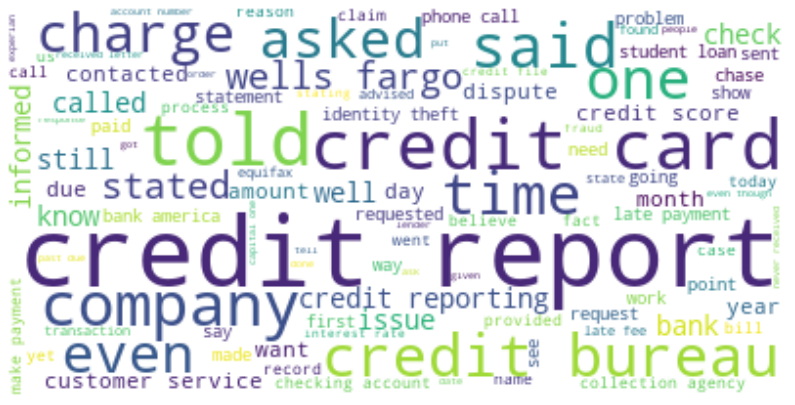

In [22]:
#creating a word cloud

#generating the text without stopwords into one string
text_wc = ' '.join(complains_token_sw)

#Generatig the wordcloud object
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_wc)
#plotting the wordcloud



plt.figure()
plt.figure(figsize = (14, 14), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

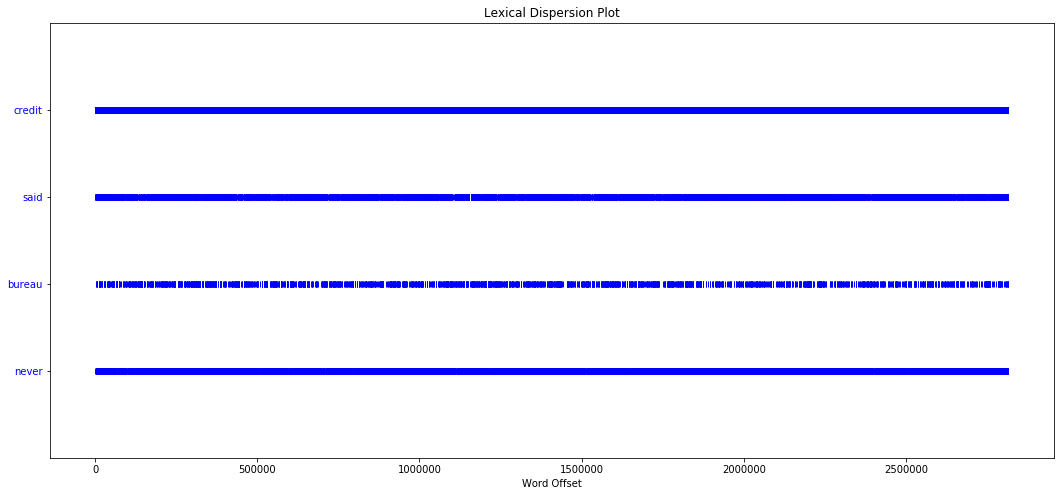

In [23]:
#

plt.figure(figsize = (18, 8), facecolor = None)
complains_textnl.dispersion_plot(['credit','said','bureau','never'])




# Saving notebook into a html file



In [24]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()

jupyter_file = "Pract2.ipynb"
output_html = "Pract2.html"

output_notebook = nbformat.read(jupyter_file, as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_html, 'w', encoding='utf-8').write(output)